<a href="https://colab.research.google.com/github/SidU/Papers/blob/main/EmbeddingsLimits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geometric limits of single-vector retrieval
**Goal:** Build intuition that low embedding dimension caps how many query-dependent rankings are possible.
Connect to **sign rank** and show practical escapes: multi-vector, hybrid, rerankers.

Based on [this paper from Deepmind](https://arxiv.org/pdf/2508.21038)



In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True, linewidth=120)
rng = np.random.default_rng(0)

Docs on a line ⇒ every query induces the same order (or its reverse).

In [2]:
docs_1d = np.array([[1.0],[2.0],[3.0]])  # three docs on a line
for q in [1.0, -1.0, 0.7]:
    scores = (docs_1d * q).ravel()
    print(f"q={q:>4}: order ->", np.argsort(-scores))

q= 1.0: order -> [2 1 0]
q=-1.0: order -> [0 1 2]
q= 0.7: order -> [2 1 0]


Notice that since the docs are dots on a single number line, the queries which are also dots on that line can only ever get the docs in order 0, 1, 2 or 2, 1, 0.

Docs on a plane; queries are directions. Projections change orderings.

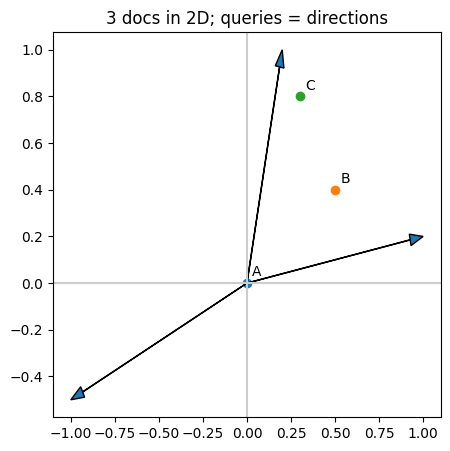

dir [1.  0.2] -> ['B', 'C', 'A']
dir [0.2 1. ] -> ['C', 'B', 'A']
dir [-1.  -0.5] -> ['A', 'B', 'C']


In [6]:
P = np.array([[0.0,0.0],   # A
              [0.5,0.4],   # B
              [0.3,0.8]])  # C
dirs = np.array([[1.0,0.2],[0.2,1.0],[-1.0,-0.5]])

fig, ax = plt.subplots(figsize=(5,5))
labels = ["A","B","C"]
for (x,y),lab in zip(P,labels):
    ax.scatter(x,y); ax.text(x+0.03,y+0.03,lab)
for i,(u,v) in enumerate(dirs):
    ax.arrow(0,0,u,v, head_width=0.05, length_includes_head=True)
ax.axhline(0,color='0.8'); ax.axvline(0,color='0.8')
ax.set_title("3 docs in 2D; queries = directions"); plt.show()

def ordering(P, d):
    s = P @ d
    return [labels[i] for i in np.argsort(-s)]

for d in dirs:
    print("dir", d, "->", ordering(P,d))

Depending on placement, 2D can realize many permutations; sample directions.

In [7]:
orders = set()
for _ in range(200):
    d = rng.normal(size=2); d /= np.linalg.norm(d)
    orders.add(tuple(ordering(P, d)))
print("distinct permutations:", len(orders), orders)

distinct permutations: 6 {('B', 'A', 'C'), ('A', 'C', 'B'), ('B', 'C', 'A'), ('C', 'B', 'A'), ('C', 'A', 'B'), ('A', 'B', 'C')}


With more docs, 2D cannot realize all n! permutations. Sample to see the cap.

In [9]:
P4 = np.array([[0.0,0.0],[1.0,0.05],[0.15,0.95],[0.9,0.4]])  # spread out
labels4 = ["A","B","C","D"]

def ordering4(P, d):
    s = P @ d
    return tuple(labels4[i] for i in np.argsort(-s))

orders4 = set()
for _ in range(8000):
    d = rng.normal(size=2); d /= np.linalg.norm(d)
    orders4.add(ordering4(P4, d))

print("distinct permutations observed:", len(orders4))  # << 24

distinct permutations observed: 12


Turn “top-1” per query into +/– signs to form a sign matrix M.

In [10]:
def sign_matrix_top1(P, dirs):
    S = []
    for d in dirs:
        v = P @ d
        m = v.max()
        S.append([1 if x==m else -1 for x in v])
    return np.array(S)

dirs_demo = np.array([[1,0.2],[0.2,1],[-1,-0.5]])
print(sign_matrix_top1(P, dirs_demo))  # rows=queries, cols=docs

[[-1  1 -1]
 [-1 -1  1]
 [ 1 -1 -1]]


Witness examples: show sign patterns realizable in 1D vs 2D.

In [11]:
# 1D witness: rows identical up to sign
d = np.array([[ 1.0],[-1.0]])  # docs
q = np.array([[ 1.0],[ 1.0]])  # queries
print("1D sign pattern:\n", np.sign(q @ d.T))

# 2D XOR witness
D = np.array([[1.0,0.0],[0.0,1.0]])          # docs
Q = np.array([[ 1.0,-1.0],[-1.0, 1.0]])      # queries
print("2D XOR sign pattern:\n", np.sign(Q @ D.T))

1D sign pattern:
 [[ 1. -1.]
 [ 1. -1.]]
2D XOR sign pattern:
 [[ 1. -1.]
 [-1.  1.]]


Try to enforce 3 cyclic orderings in 1D vs 2D. 1D fails, 2D succeeds.

In [12]:
docs = ["d1","d2","d3"]; queries = ["q1","q2","q3"]
rankings = {"q1":["d1","d2","d3"], "q2":["d2","d3","d1"], "q3":["d3","d1","d2"]}
constraints = [(q,rankings[q][i],rankings[q][i+1]) for q in queries for i in range(2)]

def fit(dim, steps=2500, lr=0.05, seed=0):
    rng = np.random.default_rng(seed)
    D = {d: rng.normal(0,0.3,dim) for d in docs}
    Q = {q: rng.normal(0,0.3,dim) for q in queries}
    for t in range(steps):
        gD = {d: np.zeros(dim) for d in docs}
        gQ = {q: np.zeros(dim) for q in queries}
        for q,a,b in constraints:
            diff = Q[q]@D[a] - Q[q]@D[b]
            if diff < 0.5:  # hinge
                gQ[q] += -(D[a]-D[b]); gD[a] += -Q[q]; gD[b] +=  Q[q]
        for d in docs: D[d] -= lr*gD[d]
        for q in queries: Q[q] -= lr*gQ[q]
    v = sum((Q[q]@D[a]) < (Q[q]@D[b]) + 0.49 for q,a,b in constraints)
    return v

print("violations in 1D:", fit(1, seed=1))
print("violations in 2D:", fit(2, seed=2))


violations in 1D: 2
violations in 2D: 0


Multi-vector (late interaction) scores queries against token vectors: MaxSim.


In [13]:
# toy doc: two aspects; toy query: attends to one aspect
q = np.array([0.0, 1.0])                # cares about aspect 2
d_single = np.array([0.6, 0.4])         # single vector averages aspects
d_multi = np.array([[1.0, 0.0],         # token/aspect vectors
                    [0.0, 1.0]])

def dense(q, d): return float(q @ d)
def maxsim(Q, D): return float(np.max(Q @ D.T))  # Q: (m,d), D: (n,d)

print("single-vector score:", dense(q, d_single))
print("multi-vector MaxSim:", maxsim(np.atleast_2d(q), d_multi))

single-vector score: 0.4
multi-vector MaxSim: 1.0


Combine dense (semantic) + sparse/BM25 (lexical). Score = α*dense+(1-α)*sparse.

In [14]:
dense_scores  = np.array([0.82, 0.40, 0.10])
sparse_scores = np.array([0.10, 0.90, 0.20])
alpha = 0.5
final = alpha*dense_scores + (1-alpha)*sparse_scores
print("final scores:", final, "order ->", np.argsort(-final))


final scores: [0.46 0.65 0.15] order -> [1 0 2]


Retrieve top-K, then rerank with a stronger cross-encoder (or reasoning).

In [15]:
retrieved = ["d1","d2","d3"]
bi_scores  = np.array([0.60, 0.55, 0.30])    # from retriever
cross_scores = np.array([0.50, 0.20, 0.90])  # from reranker
order_before = [retrieved[i] for i in np.argsort(-bi_scores)]
order_after  = [retrieved[i] for i in np.argsort(-cross_scores)]
print("before:", order_before)
print("after :", order_after)

before: ['d1', 'd2', 'd3']
after : ['d3', 'd1', 'd2']


- Single-vector retrieval has a geometric ceiling.
- 1D ⇒ one global order; higher d ⇒ more orders, still bounded.
- Sign rank ≈ minimum d to realize a sign pattern.
- Use multi-vector, hybrid, and rerankers to escape the ceiling.